## Import Necessary Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,Input,Dropout,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB4, Xception, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import warnings
warnings.filterwarnings('ignore')
from zipfile import ZipFile
import random

## Data Import

In [5]:
data_path = '/content/drive/MyDrive/datasets/dog_breed_identification/train.zip'

with ZipFile(data_path, 'r') as zip:
    zip.extractall()
    print('The data set has been extracted. | Veri seti çıkarıldı.')

The data set has been extracted. | Veri seti çıkarıldı.


In [6]:
data_train = pd.read_csv('labels.csv')
data_train.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

## Data Analysis

In [7]:
df = data_train.copy()

In [8]:
df.shape

(10222, 2)

In [9]:
df["breed"].nunique()

120

In [10]:
df["breed"].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

In [11]:
df.isna().sum()

id       0
breed    0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


#### Note : The dataset has 10322 records. It is a big data. So below It's chosed a different way to modelling by using data splitting based on "breed" counts.

In [13]:
breed_counts = df['breed'].value_counts()
included_breeds = breed_counts[breed_counts > 100].index.tolist()
df = df[df['breed'].isin(included_breeds)].reset_index(drop=True)

In [14]:
df.shape

(2184, 2)

In [15]:
df['filepath'] = 'train/' + df['id'] + '.jpg'
df.head()

id               breed  \
0  003df8b8a8b05244b1d920bb6cf451f9             basenji   
1  0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound   
2  00693b8bc2470375cc744a6391d397ec         maltese_dog   
3  00bee065dcec471f26394855c5c2f3de               cairn   
4  013f8fdf6d638c7bb042f5f17e8a9fdc     tibetan_terrier   

                                     filepath  
0  train/003df8b8a8b05244b1d920bb6cf451f9.jpg  
1  train/0042188c895a2f14ef64a918ed9c7b64.jpg  
2  train/00693b8bc2470375cc744a6391d397ec.jpg  
3  train/00bee065dcec471f26394855c5c2f3de.jpg  
4  train/013f8fdf6d638c7bb042f5f17e8a9fdc.jpg

## Image Prep

In [16]:
def read_and_resize_image_rgb(file_path):
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb_resized = cv2.resize(img_rgb, (224, 224))
    return img_rgb_resized

In [17]:
resized_images = []
for idx, filepath in enumerate(df['filepath']):
    resized_img = read_and_resize_image_rgb(filepath)
    resized_images.append(resized_img)
resized_images_array = np.array(resized_images)

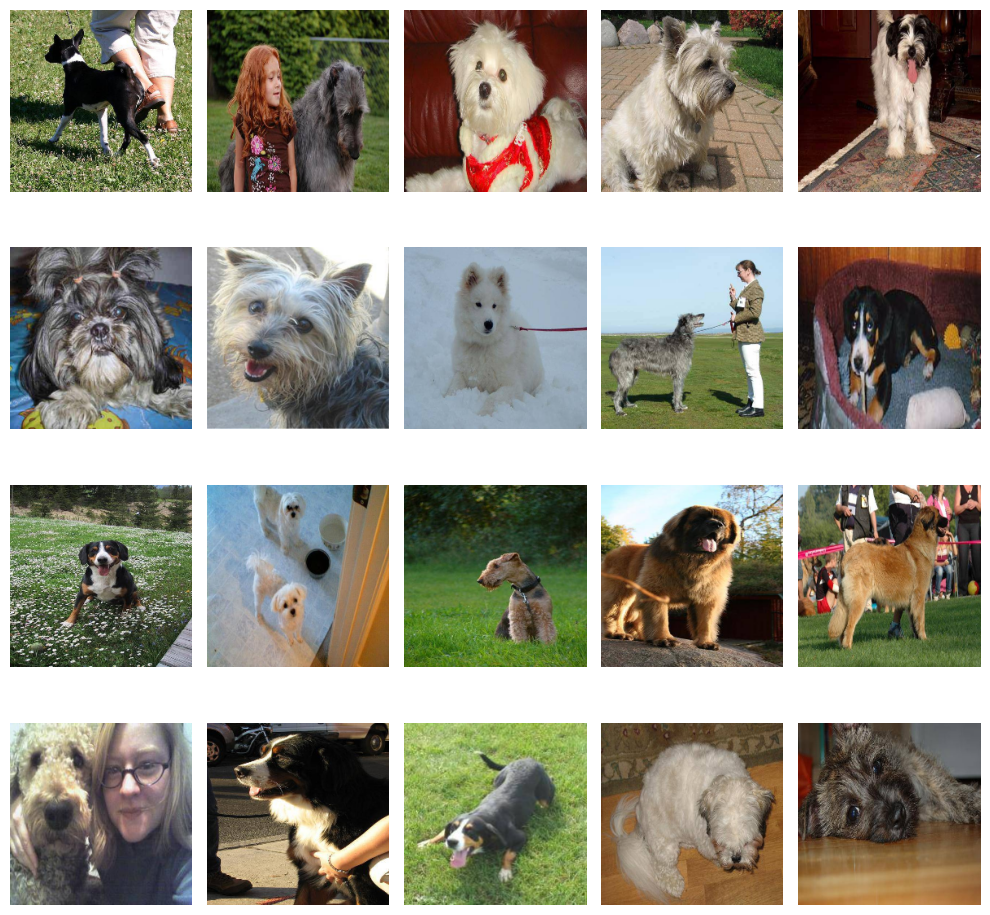

In [18]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(resized_images_array[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [19]:
class_names = df['breed'].unique()
class_names[1:10]

array(['scottish_deerhound', 'maltese_dog', 'cairn', 'tibetan_terrier',
       'shih-tzu', 'australian_terrier', 'samoyed', 'entlebucher',
       'airedale'], dtype=object)

In [20]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(df['breed'])
new_labels = to_categorical(label_encoded)

In [21]:
X = resized_images_array
y = new_labels

## Train Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [23]:
print(f'X_train.shape :  {X_train.shape}')
print(f'X_test.shape :  {X_test.shape}')
print(f'y_train.shape :  {y_train.shape}')
print(f'y_test.shape : {y_test.shape}')

X_train.shape :  (1747, 224, 224, 3)
X_test.shape :  (437, 224, 224, 3)
y_train.shape :  (1747, 20)
y_test.shape : (437, 20)


## Data Augmentation

In [24]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

In [25]:
training_set=train_datagen.flow(X_train,y=y_train,batch_size=128)
testing_set=test_datagen.flow(X_test,y=y_test,batch_size=128)

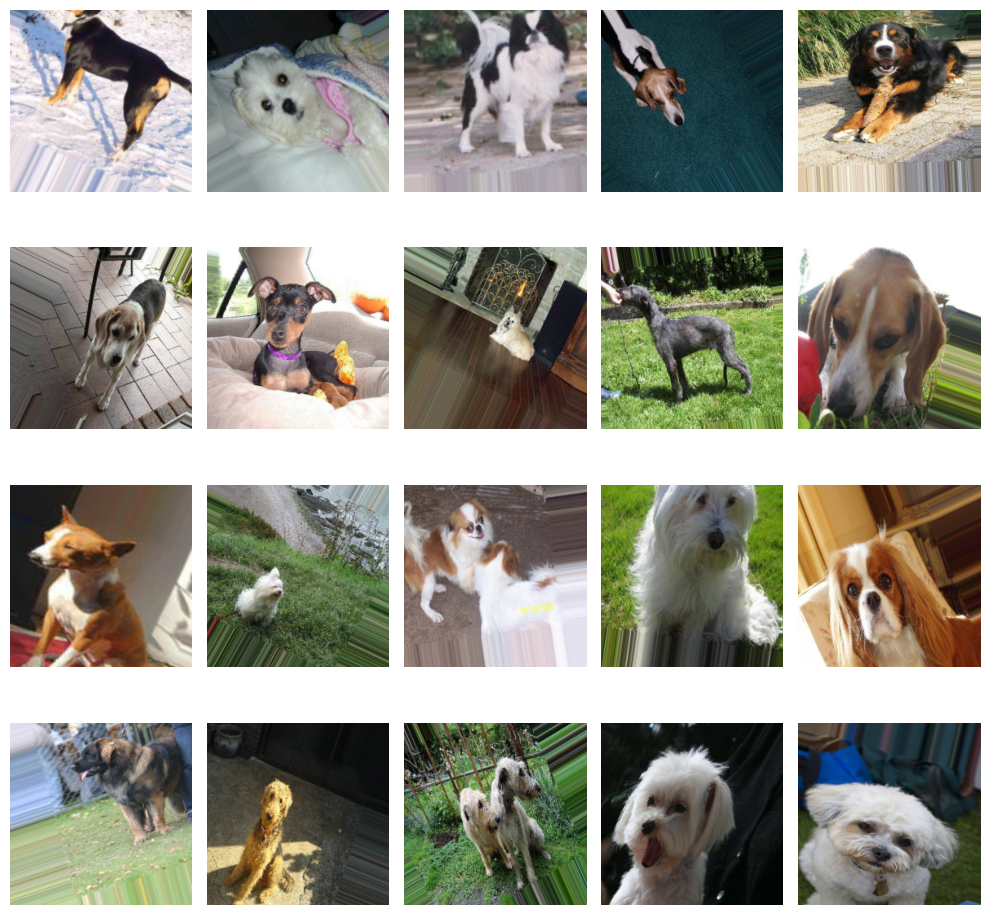

In [26]:
augmented_images = train_datagen.flow(X_train, y=y_train, shuffle=True)
plt.figure(figsize=(10, 10))
for i in range(20):
    augmented_image = augmented_images.next()[0][0]
    plt.subplot(4, 5, i + 1)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.tight_layout()
plt.show()

### CNN - Convolutional Neural Network

In [27]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='sigmoid'),
    Dropout(0.2),
    Dense(20, activation='softmax')
])

In [28]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [30]:
history=model.fit_generator(training_set,validation_data = testing_set,epochs = 10)

Epoch 1/10
14/14 [==============================] - 35s 1s/step - loss: 3.1899 - accuracy: 0.0446 - val_loss: 3.0374 - val_accuracy: 0.0297
Epoch 2/10
14/14 [==============================] - 22s 2s/step - loss: 3.0141 - accuracy: 0.0527 - val_loss: 2.9938 - val_accuracy: 0.0526
Epoch 3/10
14/14 [==============================] - 26s 2s/step - loss: 2.9744 - accuracy: 0.0733 - val_loss: 2.9160 - val_accuracy: 0.1167
Epoch 4/10
14/14 [==============================] - 22s 2s/step - loss: 2.8888 - accuracy: 0.1110 - val_loss: 2.8380 - val_accuracy: 0.1419
Epoch 5/10
14/14 [==============================] - 25s 2s/step - loss: 2.8002 - accuracy: 0.1351 - val_loss: 2.7593 - val_accuracy: 0.1648
Epoch 6/10
14/14 [==============================] - 22s 2s/step - loss: 2.7606 - accuracy: 0.1322 - val_loss: 2.6963 - val_accuracy: 0.1785
Epoch 7/10
14/14 [==============================] - 23s 2s/step - loss: 2.6835 - accuracy: 0.1626 - val_loss: 2.6230 - val_accuracy: 0.1739
Epoch 8/10
14/14 [==

## Transfer Learning

In [31]:
df = data_train.copy()

In [32]:
df.shape

(10222, 2)

In [33]:
breed_counts = df['breed'].value_counts()
included_breeds = breed_counts[breed_counts > 80].index.tolist()
df = df[df['breed'].isin(included_breeds)].reset_index(drop=True)

In [34]:
df.shape

(6372, 2)

In [35]:
df['filepath'] = 'train/' + df['id'] + '.jpg'
df.head()

id               breed  \
0  000bec180eb18c7604dcecc8fe0dba07         boston_bull   
1  00214f311d5d2247d5dfe4fe24b2303d            bluetick   
2  002211c81b498ef88e1b40b9abf84e1d  bedlington_terrier   
3  00290d3e1fdd27226ba27a8ce248ce85  bedlington_terrier   
4  003df8b8a8b05244b1d920bb6cf451f9             basenji   

                                     filepath  
0  train/000bec180eb18c7604dcecc8fe0dba07.jpg  
1  train/00214f311d5d2247d5dfe4fe24b2303d.jpg  
2  train/002211c81b498ef88e1b40b9abf84e1d.jpg  
3  train/00290d3e1fdd27226ba27a8ce248ce85.jpg  
4  train/003df8b8a8b05244b1d920bb6cf451f9.jpg

In [36]:
resized_images = []
for idx, filepath in enumerate(df['filepath']):
    resized_img = read_and_resize_image_rgb(filepath)
    resized_images.append(resized_img)
resized_images_array = np.array(resized_images)

In [37]:
class_names = df['breed'].unique()

In [38]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(df['breed'])
new_labels = to_categorical(label_encoded)

In [39]:
X = resized_images_array
y = new_labels

In [40]:
def get_features(model_name, model_preprocessor, input_size, data):
    input_layer = Input(input_size)
    preprocessor = model_preprocessor(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=avg)
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape:', feature_maps.shape)
    return feature_maps

In [41]:
effnet_preprocessor = tf.keras.applications.efficientnet.preprocess_input
effnet_features = get_features(EfficientNetB4, effnet_preprocessor, (224, 224, 3), X)

xception_preprocessor = tf.keras.applications.xception.preprocess_input
xception_features = get_features(Xception, xception_preprocessor, (224, 224, 3), X)

resnet_preprocessor = tf.keras.applications.resnet50.preprocess_input
resnet_features = get_features(ResNet50, resnet_preprocessor, (224, 224, 3), X)

200/200 [==============================] - 33s 140ms/step
Feature maps shape: (6372, 1792)
200/200 [==============================] - 31s 138ms/step
Feature maps shape: (6372, 2048)
200/200 [==============================] - 22s 97ms/step
Feature maps shape: (6372, 2048)


In [42]:
final_features = np.concatenate([effnet_features, xception_features, resnet_features], axis=-1)
print('Final feature maps shape:', final_features.shape)

Final feature maps shape: (6372, 5888)


In [43]:
model = Sequential()
model.add(Dropout(0.7, input_shape=(final_features.shape[1],)))
model.add(Dense(68, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [45]:
history = model.fit(final_features,
                    y,
                    batch_size=128,
                    epochs=20,
                    validation_split=0.2,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/20
34/40 [========================>.....] - ETA: 0s - loss: 2.1134 - accuracy: 0.5037
Epoch 1: val_accuracy improved from -inf to 0.89882, saving model to best_model.h5
40/40 [==============================] - 2s 12ms/step - loss: 1.9013 - accuracy: 0.5450 - val_loss: 0.3574 - val_accuracy: 0.8988
Epoch 2/20
38/40 [===========================>..] - ETA: 0s - loss: 0.4221 - accuracy: 0.8682
Epoch 2: val_accuracy improved from 0.89882 to 0.90824, saving model to best_model.h5
40/40 [==============================] - 0s 6ms/step - loss: 0.4186 - accuracy: 0.8695 - val_loss: 0.2975 - val_accuracy: 0.9082
Epoch 3/20
36/40 [==========================>...] - ETA: 0s - loss: 0.2973 - accuracy: 0.9058
Epoch 3: val_accuracy improved from 0.90824 to 0.91373, saving model to best_model.h5
40/40 [==============================] - 0s 7ms/step - loss: 0.2940 - accuracy: 0.9078 - val_loss: 0.2813 - val_accuracy: 0.9137
Epoch 4/20
38/40 [===========================>..] - ETA: 0s - loss: 0.2139 

## Model Evaluation

In [46]:
best_model = load_model('best_model.h5')

In [47]:
all_predictions = best_model.predict(final_features)
all_predicted_labels = np.argmax(all_predictions, axis=1)
true_labels = np.argmax(y, axis=1)

200/200 [==============================] - 1s 3ms/step


## Confusion Matrix

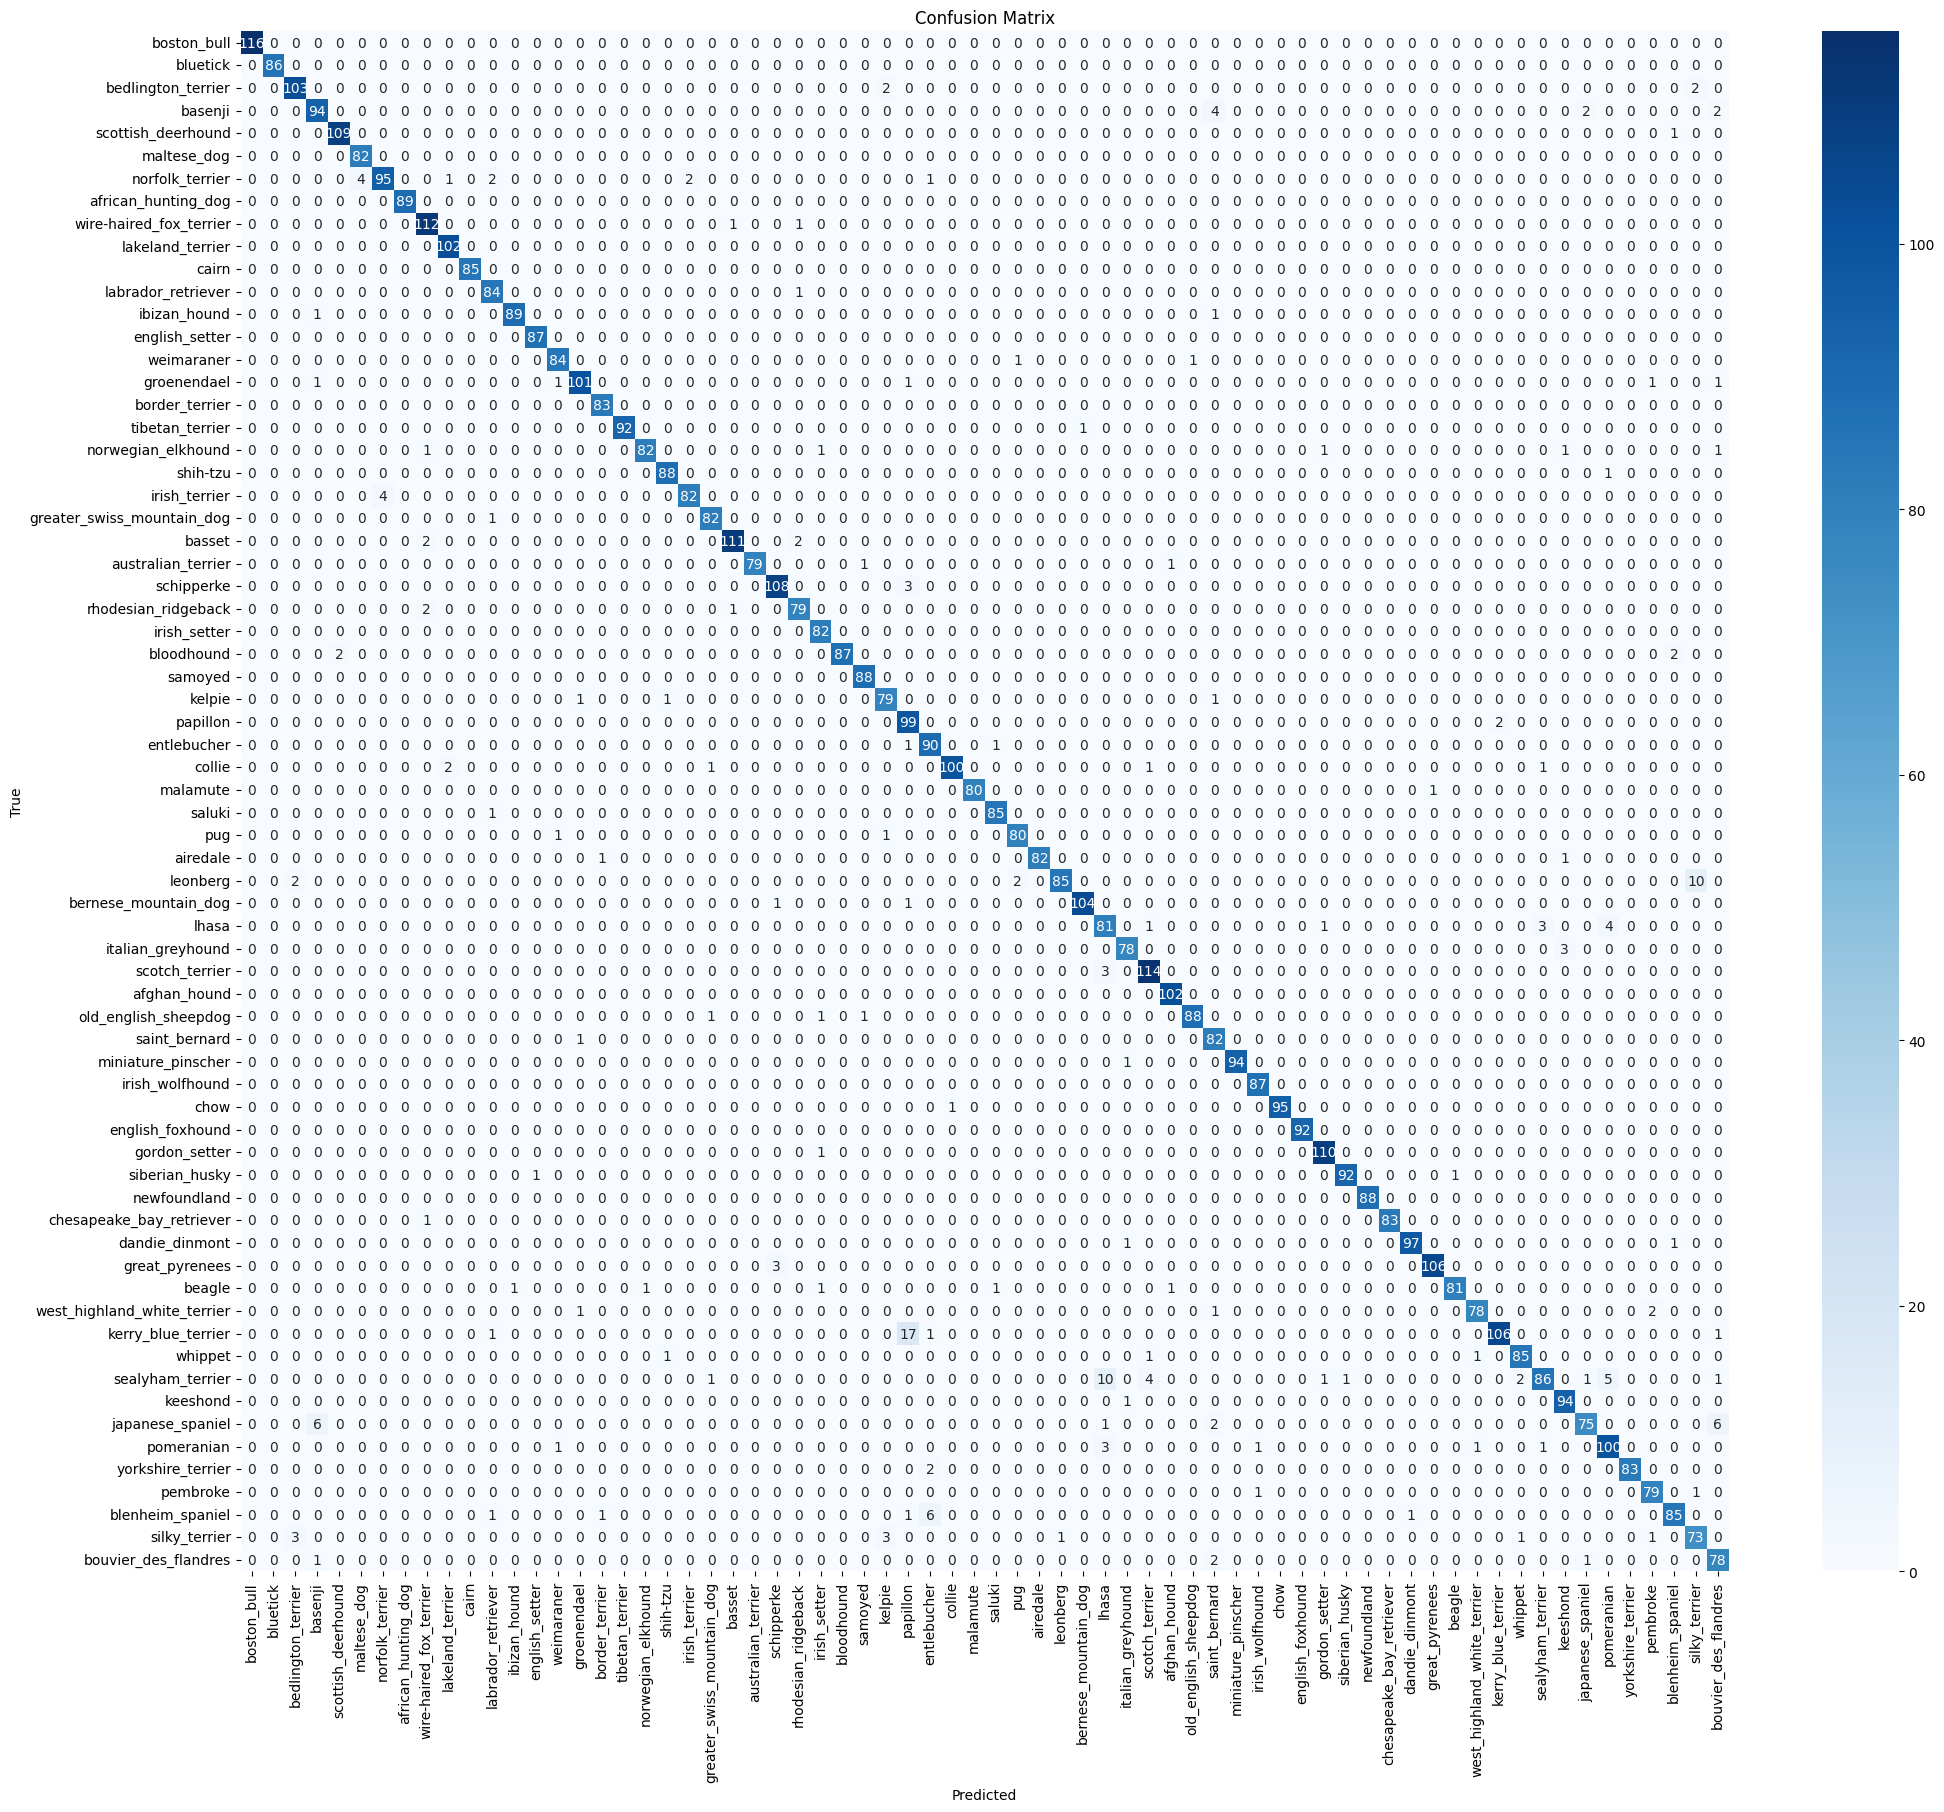

In [48]:
conf_matrix = confusion_matrix(true_labels, all_predicted_labels)

plt.figure(figsize=(24, 20))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Plot Predictions

In [49]:
random.seed(6)
random_indices = random.sample(range(len(resized_images)), 20)

In [50]:
def plot_images(images, predicted_labels, true_labels, class_names):
    plt.figure(figsize=(15, 10))
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        pred_label = predicted_labels[i]
        true_label = true_labels[i]
        if pred_label == true_label:
            title_color = 'green'
        else:
            title_color = 'red'
        plt.title(f"Predicted: {pred_label}\nTrue: {true_label}", color=title_color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [51]:
images_random_20 = [resized_images[i] for i in random_indices]
predicted_labels_random_20 = all_predicted_labels[random_indices]
true_labels_random_20 = true_labels[random_indices]

In [52]:
predicted_labels_names = label_encoder.inverse_transform(predicted_labels_random_20)
true_labels_names = label_encoder.inverse_transform(true_labels_random_20)

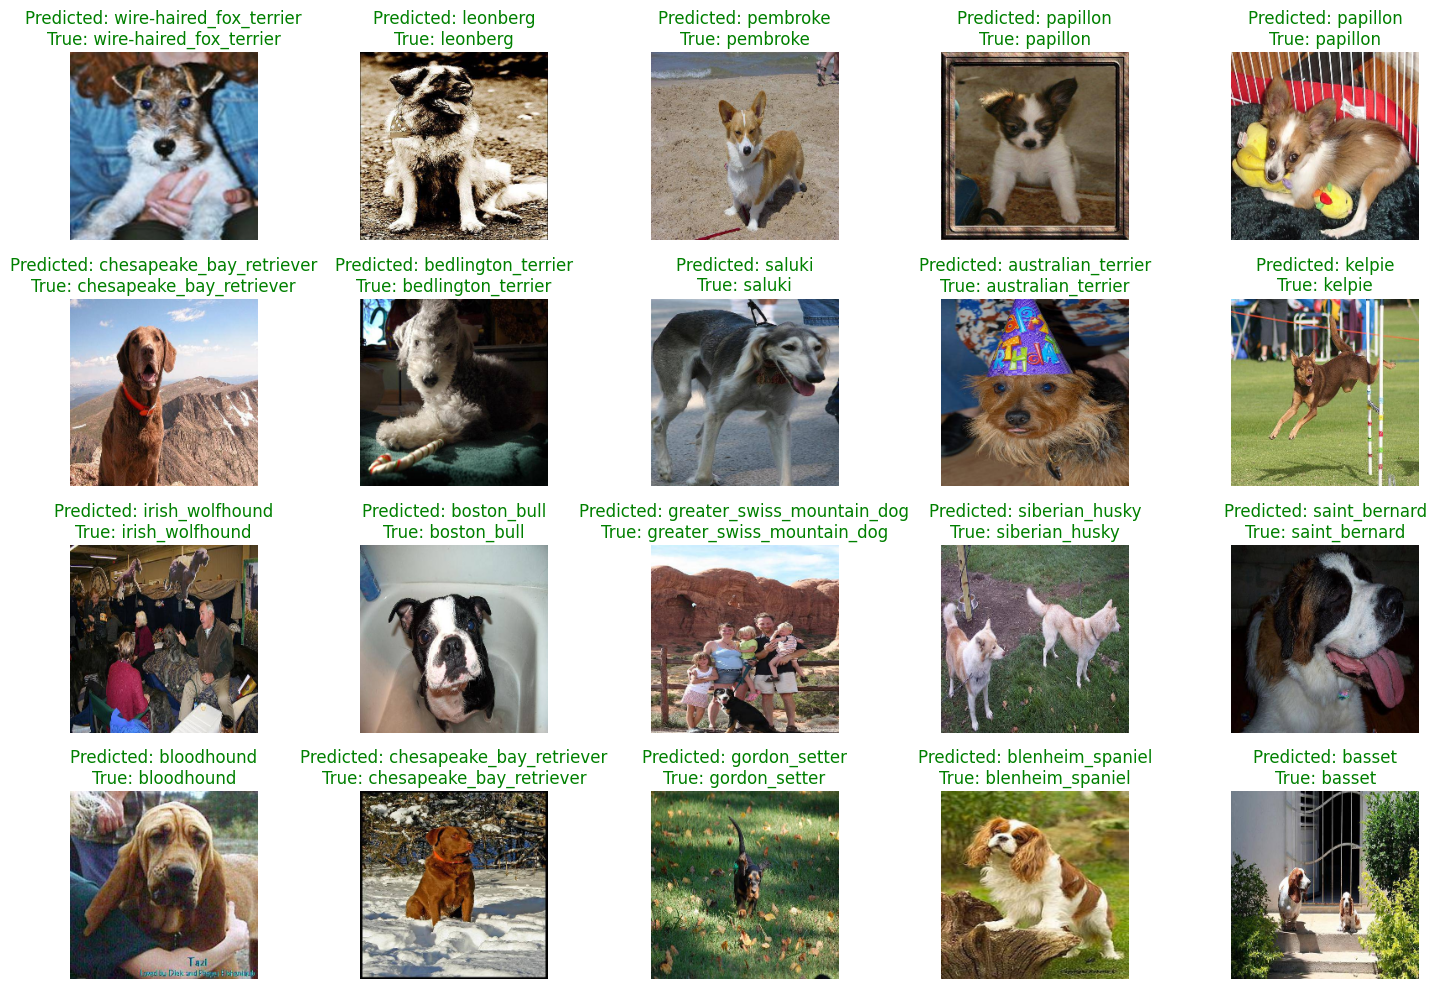

In [53]:
plot_images(images_random_20, predicted_labels_names, true_labels_names, class_names)